<a href="https://colab.research.google.com/github/czymara/czymara.github.io/blob/master/files/teach/topic_models_BIGSSS_23_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic models in R

## First: Install all packages

In [ ]:
# Packages that we will need for this exercise
packages <- c("quanteda", "stm", "BTM", "keyATM")

install.packages(packages)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘listenv’, ‘parallelly’, ‘ISOcodes’, ‘foreach’, ‘shape’, ‘future’, ‘globals’, ‘mvtnorm’, ‘fastmatch’, ‘Rcpp’, ‘RcppParallel’, ‘SnowballC’, ‘stopwords’, ‘RcppArmadillo’, ‘glmnet’, ‘lda’, ‘matrixStats’, ‘quadprog’, ‘slam’, ‘future.apply’, ‘ggrepel’, ‘matrixNormal’, ‘pgdraw’, ‘RcppEigen’




## Data: South Park scripts, first five seasons

https://github.com/EmilHvitfeldt/R-text-data#southparkdata

In [ ]:
library(purrr)

urls <- paste0("https://raw.githubusercontent.com/BobAdamsEE/SouthParkData/master/by-season/Season-", 1:19, ".csv")

south_park_data <- map_df(urls[1:5], ~ read.csv(.x)) # First X episodes only

What happens in South Park? Example: The very beginning (searson 1, episode 1):

In [ ]:
south_park_data$Character[1]
south_park_data$Line[1]

south_park_data$Character[5]
south_park_data$Line[5]

south_park_data$Character[6]
south_park_data$Line[6]

[1] "Boys"

[1] "School day, school day, teacher's golden ru...\n"

[1] "Cartman"

[1] "Yeah, go home you little dildo.\n"

[1] "Kyle"

[1] "Dude, don't call my brother a dildo!\n"

## Preprocessing the data

Remeber, we want data in a document-feature-matrix, where the texts (documents) are in the rows and the terms (features) in the columns.

In [ ]:
library(quanteda)

# we only want to keep the main characters
south_park_data <- south_park_data[south_park_data$Character == "Cartman" | south_park_data$Character == "Kyle" |
                                     south_park_data$Character == "Stan" | south_park_data$Character == "Kenny" , ]



corpus <- corpus(as.character(south_park_data$Line),
                 docvars = data.frame(season = south_park_data$Season,
                                      episode = south_park_data$Episode,
                                      char = south_park_data$Character
                 ))


toks <- tokens(corpus, remove_punct = T,
               remove_numbers = T,
               remove_symbols = T,
               remove_separators = T,
               split_hyphens = T,
               remove_url = T,
               include_docvars = T)

toks <-  tokens_remove(toks, stopwords(source = "stopwords-iso"), case_insensitive = TRUE)


toks <- tokens_wordstem(toks)

south_park_dfm <- dfm(toks)

south_park_dfm <- dfm_trim(south_park_dfm,
                           max_docfreq = 0.20,
                           min_docfreq = 0.001,
                           docfreq_type = "prop")

south_park_dfm <- south_park_dfm[!rowSums(south_park_dfm) == 0, ] # remove empty rows

nrow(south_park_dfm)
ncol(south_park_dfm)

Package version: 3.3.1
Unicode version: 13.0
ICU version: 66.1

Parallel computing: 2 of 2 threads used.

See https://quanteda.io for tutorials and examples.



[1] 7881

[1] 470

## Running the topic model

Here, we chose a model with 50 topics.

stm v1.3.6 successfully loaded. See ?stm for help. 
 Papers, resources, and other materials at structuraltopicmodel.com



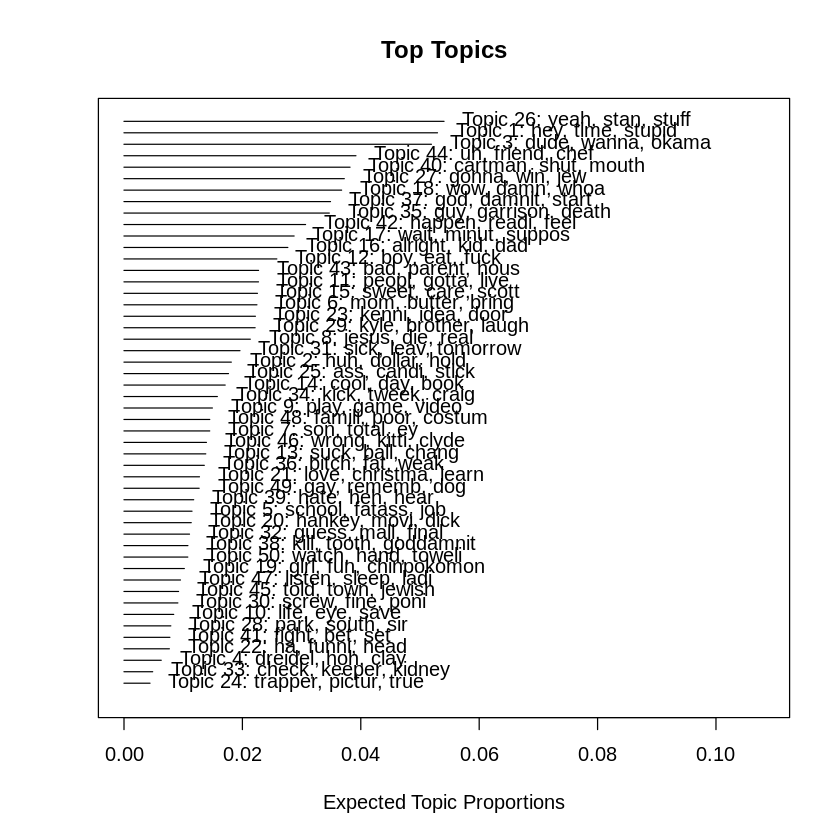

In [ ]:
library(stm)

# number of topics
k <- 50

set.seed(1337)
south_park_topics <- stm(south_park_dfm,
                     K = k,
                     prevalence = ~char+season,
                     max.em.its = 50,
                     verbose = FALSE
                     )

plot(south_park_topics)

## Test for differences accross characters

Now we know which topics occur. But how does this differ accross the four main characters?

First, we need to run the model that estimates the relationships between topics and covariates.

In [ ]:
characters_diff <- estimateEffect(1:k ~ char*season,
                              south_park_topics,
                              meta = south_park_dfm@docvars
                              )

Now we can check how each topic is associated with each character. For example, who uses the [Dreidel](https://www.youtube.com/watch?v=VfmzVc3RJOM&) topic most?

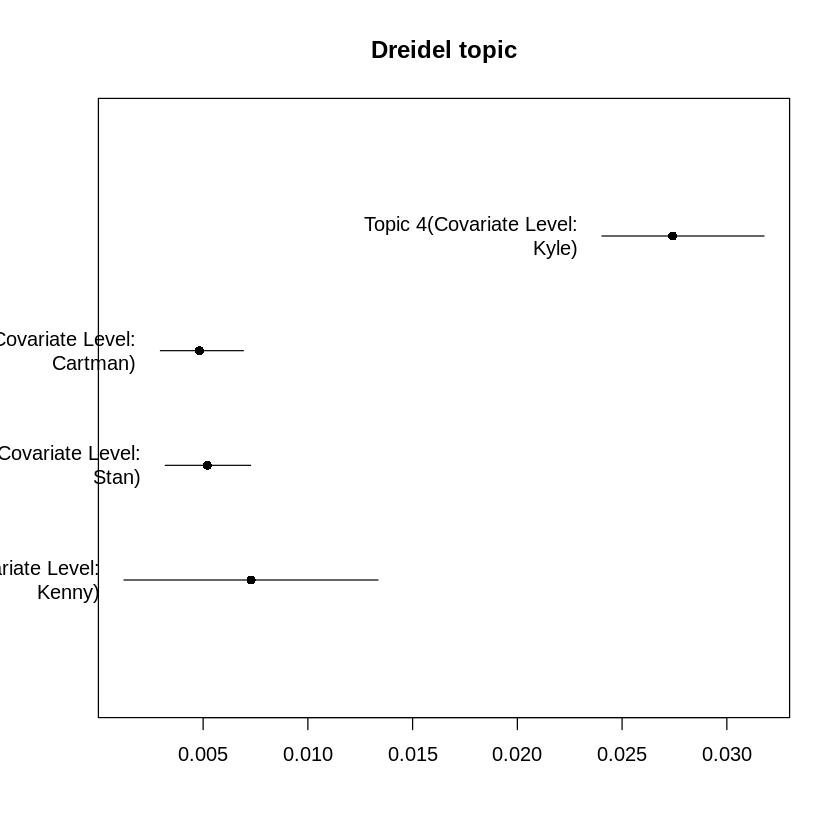

In [ ]:
plot(characters_diff,
     topics = 4,
     covariate = "char",
     method = "pointestimate",
     main = "Dreidel topic"
     )

Who swears the most (as captured by topic 12)?

Topic 12 Top Words:
 	 Highest Prob: boy, eat, fuck, ike, shit, scare, word 
 	 FREX: fuck, boy, scare, word, eat, holi, televis 
 	 Lift: fuck, scare, televis, word, boy, holi, notic 
 	 Score: holi, boy, fuck, eat, ike, scare, shit 

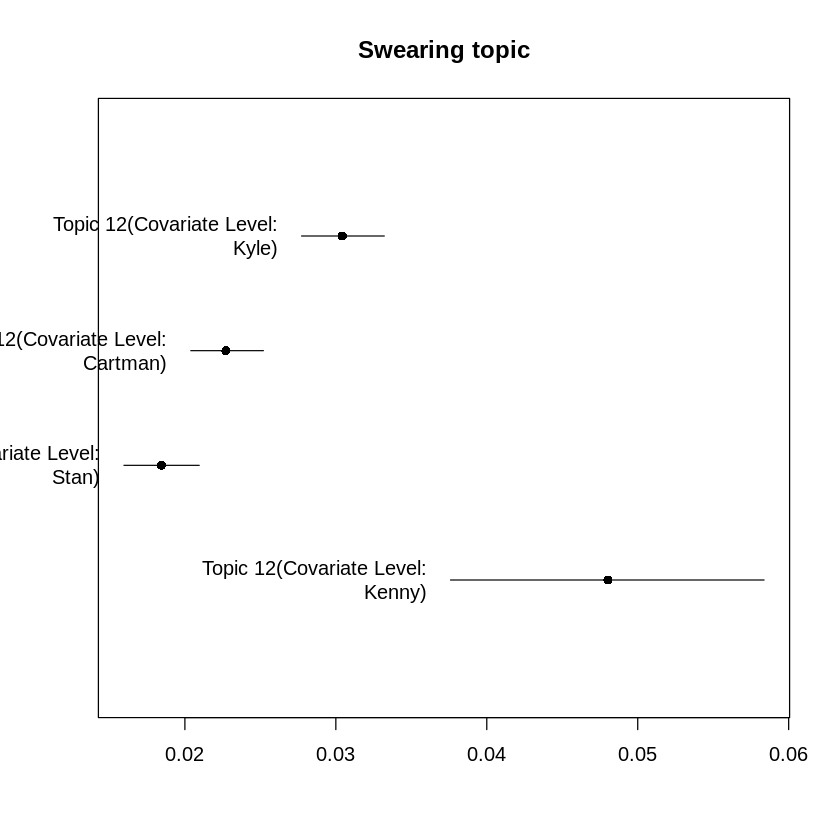

In [ ]:
labelTopics(south_park_topics, 12)

plot(characters_diff,
     topics = 12,
     covariate = "char",
     method = "pointestimate",
     main = "Swearing topic"
     )

Finally, how does the use of the swear word topic develop over time (i.e. over seasons)?

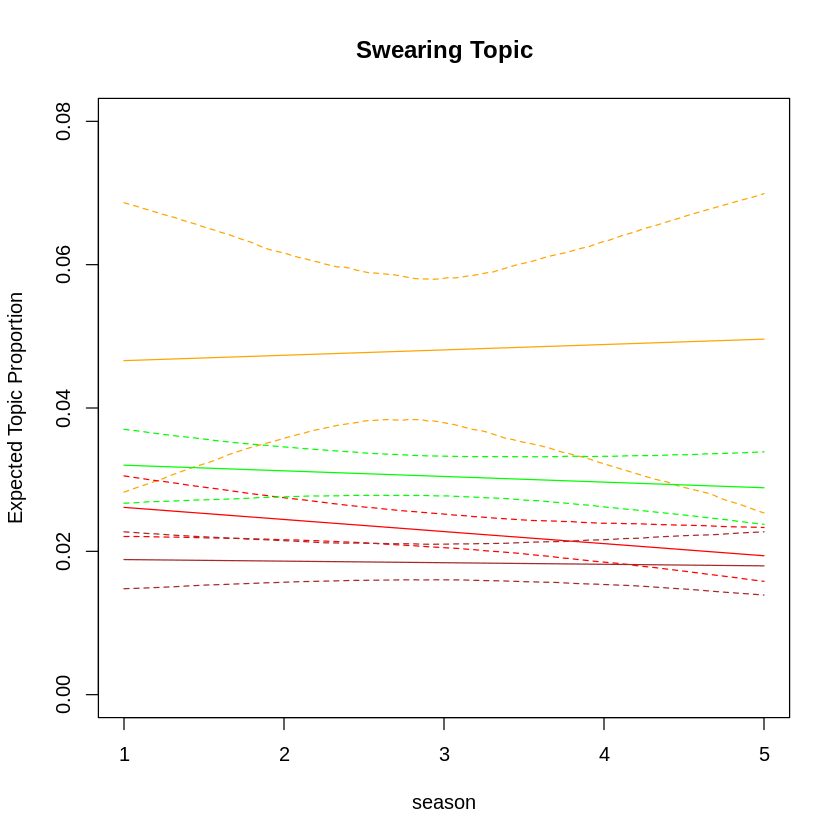

In [ ]:
# Start with Kenny
plot(characters_diff,
     topics = c(12),
     covariate = "season",
     method = "continuous",
     xlab = "season",
     ylim = c(0, 0.08),
     moderator = "char",
     moderator.value = "Kenny",
     linecol = "orange",
     printlegend = F,
     main = "Swearing Topic")

 # add Cartman
plot(characters_diff,
     topics = c(12),
     covariate = "season",
     method = "continuous",
     xlab = "season",
     ylim = c(0, 0.08),
     moderator = "char",
     moderator.value = "Cartman",
     linecol = "red",
     add = T,
     printlegend = F)

# add Kyle
plot(characters_diff,
     topics = c(12),
     covariate = "season",
     method = "continuous",
     xlab = "season",
     ylim = c(0, 0.08),
     moderator = "char",
     moderator.value = "Kyle",
     linecol = "green",
     add = T,
     printlegend = F)

# add Stan
plot(characters_diff,
     topics = c(12),
     covariate = "season",
     method = "continuous",
     xlab = "season",
     ylim = c(0, 0.08),
     moderator = "char",
     moderator.value = "Stan",
     linecol = "brown",
     add = T,
     printlegend = F)

# Alternatives to STM

## Biterm Topic Models

Biterm Topic Models (BTM) find topics in collections of short texts. How long are the lines on average?

In [ ]:
# number of characters
mean(nchar(south_park_data$Line))

sd(nchar(south_park_data$Line))

[1] 48.30204

[1] 54.36496

BTM is a word co-occurrence based topic model that learns topics by modeling word-word cooccurrences patterns which are called biterms ([vignette](https://cran.r-project.org/web/packages/BTM/BTM.pdf)). First, we need to reshape the data.

In [ ]:
library(tidyr)

# convert to data.frame
toks_2 <- convert(south_park_dfm, to = "data.frame")

toks_2 <- toks_2 %>%
  pivot_longer(cols = c(!doc_id), names_to = "tokens")


toks_2 <- toks_2[toks_2$value > 0, ]


toks_2 <- toks_2[, c("doc_id", "tokens")]

Run the model.

In [ ]:
library(BTM)

set.seed(1234)
bi_topics  <- BTM(toks_2,
                  k = k,
                  background = TRUE # first topic is set to a background topic, can be used to filter out common words
                  )

terms(bi_topics, top_n = 10)

,token,probability
,<chr>,<dbl>
1,dude,0.03986829
2,yeah,0.03408208
3,cartman,0.02990130
4,guy,0.02943305
5,gonna,0.02545295
6,hey,0.02381408
7,god,0.01692415
8,kenni,0.01669002
9,mom,0.01475014


## Keyword Assisted Topic Model

An important advantage of the proposed keyword-assisted topic
model (keyATM) is that the specification of keywords requires researchers to label topics prior to fitting a model to the data. ([Eshima et al. 2023](https://onlinelibrary.wiley.com/doi/full/10.1111/ajps.12779))

In [ ]:
library(keyATM)

keyATM_docs <- keyATM_read(texts = south_park_dfm)

keywords <- list(
  kenny        = c("oh", "my", "god", "they", "killed", "kenny"),
  topic2     = c("a", "b", "c"), # ... fill in topics that you expect to find here
  topic3     = c("d", "e", "f")  # ... and here
  )


keyATM 0.5.0 successfully loaded.
 Papers, examples, resources, and other materials are at
 https://keyatm.github.io/keyATM/

ℹ Using quanteda dfm.



Run the model.

In [ ]:
key_topics <- keyATM(
  docs              = keyATM_docs,  # text input
  no_keyword_topics = 48,           # number of topics without keywords
  keywords          = keywords,     # keywords
  model             = "base",       # select the model
  options           = list(seed = 1337)
  )

top_words(key_topics)

⠙ Initializing the model

Warning message:
“Keywords are pruned because they do not appear in the documents: oh, my, they,
killed, kenny, a, b, c, d, e, and f”


ERROR: ignored

✖ Initializing the model s]





How often do these topics appear?

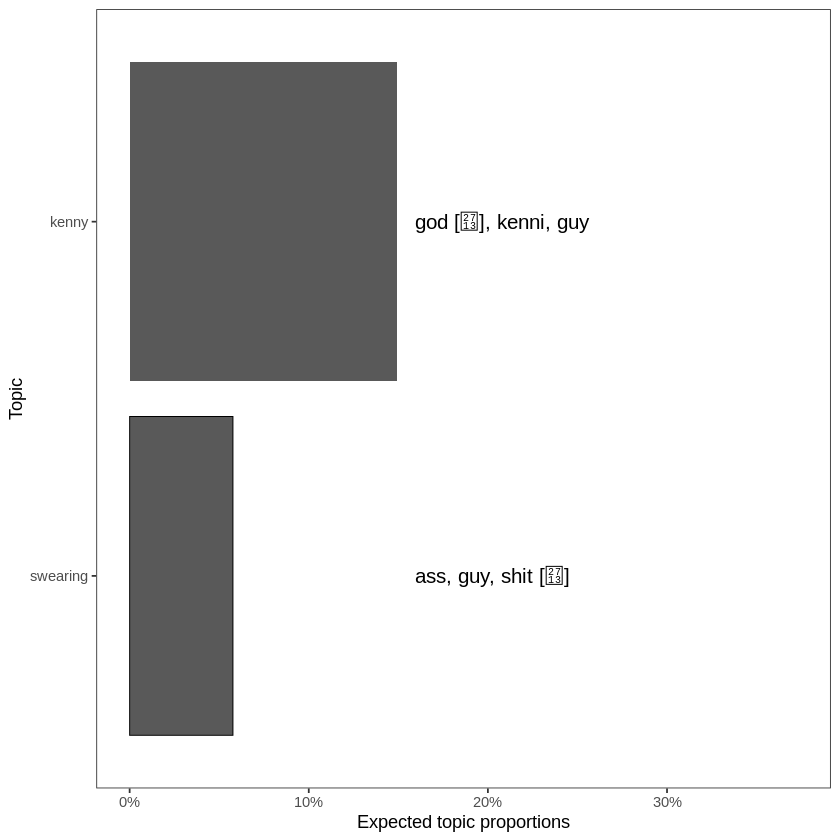

In [ ]:
plot_topicprop(key_topics, show_topic = 1:2)